# Simultaneous least squares fit

## Formulas

### Damped harmonic oscillator
Differential equation:
$$m \ddot x = -k x - \alpha \dot x$$
After dividing by $m$ one obtains
$$\ddot x + 2 \beta \dot x + \omega_0^2 x = 0; \quad \beta = \frac{\alpha}{2m}$$
In case of undercritical damping ($\beta < \omega_0$) the solution is :
$$x(t) = x_0 e^{- \beta t} \cos(\omega t + \varphi_0); \quad \omega = \sqrt{\omega_0^2 - \beta^2}$$
 
### Driven harmonic oscillator
Differential equation:
$$\ddot x + 2 \beta \dot x + \omega_0^2 x = K \cos \omega t; \quad K = \frac{f}{m}$$

Ansatz:
$$x(t) = A \cos (\omega t + \varphi) $$

Solution
$$A(\omega) = \frac{f/m}{\sqrt{(\omega^2 - \omega_0^2)^2 + 4 \beta^2 \omega^2}}$$

Phase shift between driving force and oscillator:
$$\tan \varphi = \frac{2 \beta \omega}{\omega^2 - \omega_0^2}, \quad -\pi \le \varphi \le 0$$

## Tasks

a) Fit the $x(t)$, $A(\omega)$ individually using the method of least squares

b) Fit $x(t)$ and $A(\omega)$ simultaneously. More generally, what is the reasoning behind such a combined fit?

Use the data generation provided in `S01_least_squares_02_generate_data.ipynb` and read it in as sketched below.

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


In [1]:
import numpy as np
from numpy import exp, cos, sqrt
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import rcParams

In [2]:
# Default plot style
rcParams['axes.linewidth'] = 2
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = (5,10)

rcParams['figure.figsize'] = (12, 7)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

# Fit parameters
# box design
props = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.5)

# make a box with parameters in plot
def textstrer(title, params, err_params, units, labels, a, b, r = 2, 
              fonts = 14, ax = plt):
    textstr = np.array([title + '\n'])
    
    for i in range(len(params)):
        textstr = np.append(textstr, 
                            '${} = {} \pm {}\ {}$' .
                            format(labels[i],
                                   round(params[i], r),
                                   round(err_params[i], r),
                                   units[i]
                                  )) # Create a textstring w/ all parameters
    ax.text(a, b, ''.join(map(lambda x: x[:] + '\n', textstr)),
            verticalalignment = 'top', fontsize = fonts, bbox = props)

## Read data

In [3]:
t_data, x_data, sigma_x = np.loadtxt('damped_free_oscillator.csv', delimiter=',', unpack=True)
omega_data, A_data, sigma_A, ph_data, sigma_ph = np.loadtxt('driven_oscillator.csv', 
                                                            delimiter=',', unpack=True)

## Solution

a) First we want to fit $x(t)$ and $A(\omega)$ individually using the method of least squares. In the first exercise to the least squares method, this was quite trivial because we used an analytical formula for a linear fit. In this case, we will proceed similarly but more carefully, since we can't use this formula this time. However, we learned a method to do the work for us with the Minuit funciton.

We want to determine the optimal fit parameters for the dampened harmonic oscillator. 

$$ x(t) = x_0 \mathrm{e}^{-\beta t} \cos{(\sqrt{\omega_0^2 - \beta^2}\, t + \varphi_0)} $$

and for the driven harmonic oscillator

$$ A(\omega) = \dfrac{\frac{f}{m}}{\sqrt{(\omega^2 - \omega_0)^2 +4 \beta^2 \omega^2}}. $$

In [4]:
def x_damp(t, x_0, beta, omega_0, phi_0):
    return (x_0 * exp(-beta * t) * 
            cos(sqrt(omega_0 ** 2 - beta ** 2) * t + phi_0))

def A_driven(omega, K, omega_0, beta):
    return K / sqrt( (omega**2 - omega_0**2) ** 2 + 4 * beta**2 * omega**2)

We will use the Minuit function to determine the $\chi^2$ distributions for each of these functions.

In [5]:
# define chi_sq as a function of parameters
''' It's best if we do this separately for both functions, x and A because
when we apply the Minuit function, we only want chi_sq to be dependent on the
parameters ''' 
def chi_sq_x(parameters):
    return np.sum((x_data - x_damp(t_data, *parameters)) ** 2 / (sigma_x ** 2))
#    return np.sum((x_data - x_damp(t_data, x_0, beta, omega_0, phi_0))
 #                 ** 2 / sigma_x ** 2 )


def chi_sq_A(parameters):
    return np.sum((A_data - A_driven(omega_data, *parameters)) ** 2 
                  / (sigma_A ** 2))


# Best Fit for the damped harmonic oscillator
params_x = [0.1, 0.1, 1, 1]
chi_sq_x.errordef = Minuit.LEAST_SQUARES
m_x = Minuit(chi_sq_x, params_x)
m_x.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.15                      │              Nfcn = 393              │
│ EDM = 2.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.0979   │  0.0030   │            │            │         │         │       │
│ 1 │ x1   │   0.282   │   0.014   │            │            │         │         │       │
│ 2 │ x2   │   4.027   │   0.014   │            │            │         │         │       │
│ 3 │ x3   │  -0.033   │   0.034   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────┐
│    │        x0        x1        x2        x3 │
├────┼─────────────────────────────────────────┤
│ x0 │  8.74e-06  2.74e-05 -1.66e-06   1.1e-05 │
│ x1 │  2.74e-05  0.000182  -1.3e-07  3.68e-05 │
│ x2 │ -1.66e-06  -1.3e-07  0.000208 -0.000363 │
│ x3 │   1.1e-05  3.68e-05 -0.000363   0.00118 │
└────┴─────────────────────────────────────────┘

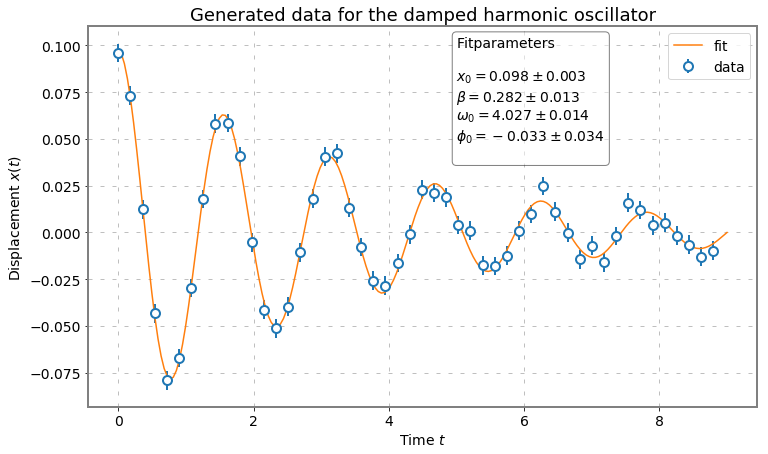

In [6]:
# Plot
t_lin = np.linspace(0, 9, 200)

fig, ax = plt.subplots()
ax.set_title('Generated data for the damped harmonic oscillator')
ax.errorbar(t_data, x_data, sigma_x, fmt = 'o', fillstyle = 'none', 
           markeredgewidth = 2, markersize = 9, mfc='w', linewidth = 2,
           label = 'data')
ax.plot(t_lin, x_damp(t_lin, *m_x.values), label='fit')

# Here we make the little box with the fitparameters
units = ['', '', '', '']
labels = ['x_0', '\\beta', '\\omega_0', '\\phi_0']
textstrer('Fitparameters', [*m_x.values], [*m_x.errors], 
          units, labels, 5, 0.105, 3)

ax.set_xlabel('Time $t$')
ax.set_ylabel('Displacement $x(t)$')

ax.legend(loc = 'best')
fig.show()

In [7]:
# Best Fit for the amplitude of the driven harmonic oscillator
params_A = [1, 1, 1]
chi_sq_A.errordef = Minuit.LEAST_SQUARES
m_A = Minuit(chi_sq_A, params_A)
m_A.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 34.3                       │              Nfcn = 370              │
│ EDM = 0.000109 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.199   │   0.005   │            │            │         │         │       │
│ 1 │ x1   │   4.000   │   0.009   │            │            │         │         │       │
│ 2 │ x2   │   0.301   │   0.012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │ 2.53e-05 6.16e-06 5.12e-05 │
│ x1 │ 6.16e-06  8.5e-05 7.36e-06 │
│ x2 │ 5.12e-05 7.36e-06 0.000133 │
└────┴────────────────────────────┘

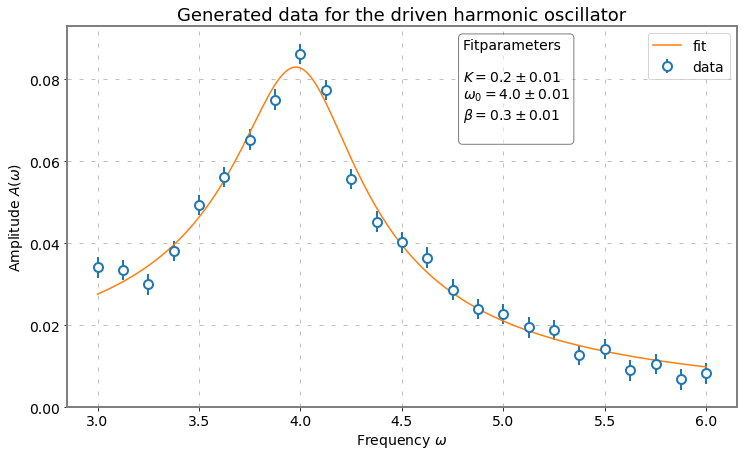

In [8]:
# Plot
omega_lin = np.linspace(3, 6, 200)

fig, ax = plt.subplots()
ax.set_title('Generated data for the driven harmonic oscillator')
ax.errorbar(omega_data, A_data, sigma_A, fmt = 'o', fillstyle = 'none', 
           markeredgewidth = 2, markersize = 9, mfc='w', linewidth = 2,
           label = 'data')
ax.plot(omega_lin, A_driven(omega_lin, *m_A.values), label='fit')

# Here we make the little box with the fitparameters
units = ['', '', '']
labels = ['K', '\\omega_0', '\\beta']
textstrer('Fitparameters', [*m_A.values], [*m_A.errors], 
          units, labels, 4.8, 0.09, 2)

ax.set_xlabel('Frequency $\\omega$')
ax.set_ylabel('Amplitude $A(\\omega)$')

ax.legend(loc = 'best')
fig.show()

b) Now we want to fit both $x$ and $A$ simultaneously by calculating the combined $\chi^2$. This makes sense since we have partially the same parameters appearing in both functions so if we calculate the combined $\chi^2$ we can make sure that we're finding a shared minimum instead of a local minimum corresponding to only one of the functions. The combined $\chi^2_{\mathrm{comb}}$ is the sum of the individual $\chi^2$.

It also makes sense, if two measurements were performed under the same conditions, that the shared parameters should be exactly equal in both cases.

In [9]:
# combined chi_squared function
def chi_sq_comb(x_0, beta, omega_0, phi_0, K):
    return chi_sq_x([x_0, beta, omega_0, phi_0]) + chi_sq_A([K, omega_0, beta])

# minimizing chi2_sim
chi_sq_comb.errordef = Minuit.LEAST_SQUARES
m_comb = Minuit(chi_sq_comb, x_0= 0.1, omega_0=3.0, beta=0.3, K = 0.2, phi_0=0)
m_comb.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 68.08                      │              Nfcn = 394              │
│ EDM = 0.000105 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x_0     │  0.0998   │  0.0025   │            │            │         │         │       │
│ 1 │ beta    │   0.294   │   0.009   │            │            │         │         │       │
│ 2 │ omega_0 │   4.007   │   0.008   │            │            │         │         │       │
│ 3 │ phi_0   │   0.003   │   0.027   │            │            │         │         │       │
│ 4 │ K       │   0.197   │   0.004   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────┐
│         │       x_0      beta   omega_0     phi_0         K │
├─────────┼───────────────────────────────────────────────────┤
│     x_0 │  6.38e-06   1.1e-05  1.87e-07   4.4e-06  4.25e-06 │
│    beta │   1.1e-05  7.58e-05  3.23e-06  6.85e-06  2.94e-05 │
│ omega_0 │  1.87e-07  3.23e-06  5.96e-05 -0.000101  3.44e-06 │
│   phi_0 │   4.4e-06  6.85e-06 -0.000101  0.000711 -1.06e-06 │
│       K │  4.25e-06  2.94e-05  3.44e-06 -1.06e-06  1.69e-05 │
└─────────┴───────────────────────────────────────────────────┘

In [10]:
m_comb_A_values = [m_comb.values[4], m_comb.values[2], m_comb.values[1]]
m_comb_A_errors = [m_comb.errors[4], m_comb.errors[2], m_comb.errors[1]]
m_comb_x_values = m_comb.values[0:4]
m_comb_x_errors = m_comb.errors[0:4]

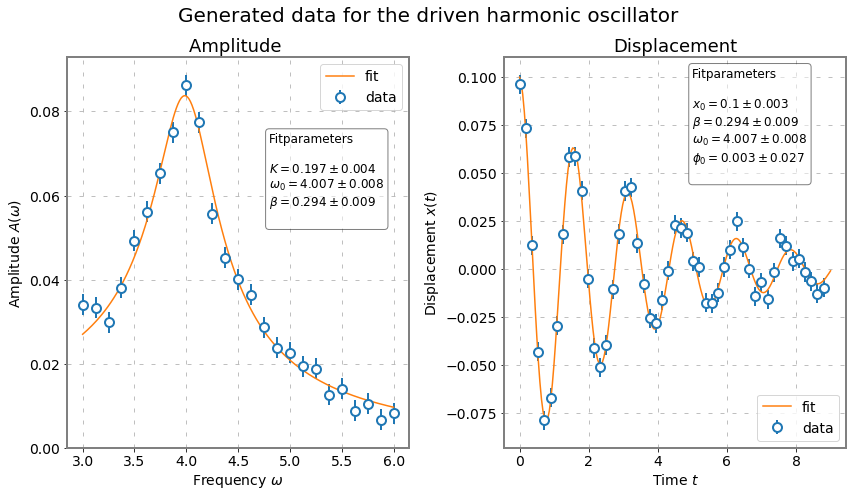

In [11]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Generated data for the driven harmonic oscillator\n\n', size = 20)
ax1.set_title('Amplitude ')
ax1.errorbar(omega_data, A_data, sigma_A, fmt = 'o', fillstyle = 'none', 
           markeredgewidth = 2, markersize = 9, mfc='w', linewidth = 2,
           label = 'data')
ax1.plot(omega_lin, A_driven(omega_lin, *m_comb_A_values), label='fit')

# Here we make the little box with the fitparameters
units = ['', '', '']
labels = ['K', '\\omega_0', '\\beta']
textstrer('Fitparameters', [*m_comb_A_values], [*m_comb_A_errors], 
          units, labels, 4.8, 0.075, 3, ax = ax1, fonts = 12)

ax1.set_xlabel('Frequency $\\omega$')
ax1.set_ylabel('Amplitude $A(\\omega)$')

ax1.legend(loc = 'best')


# # # # # # # # #
ax2.set_title('Displacement')
ax2.errorbar(t_data, x_data, sigma_x, fmt = 'o', fillstyle = 'none', 
           markeredgewidth = 2, markersize = 9, mfc='w', linewidth = 2,
           label = 'data')
ax2.plot(t_lin, x_damp(t_lin, *m_comb_x_values), label='fit')

# Here we make the little box with the fitparameters
units = ['', '', '', '']
labels = ['x_0', '\\beta', '\\omega_0', '\\phi_0']
textstrer('Fitparameters', [*m_comb_x_values], [*m_comb_x_errors], 
          units, labels, 5, 0.105, 3, ax = ax2, fonts = 12)

ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Displacement $x(t)$')

ax2.legend(loc = 'lower right')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

We can now compare the results we got for the combined fit and the individual ones. We will use compare to the oscillator parameters that were used to generate the data:

In [12]:
omega_0 = 4
beta = 0.3
x0 = 0.1
K = 0.2

pars = [omega_0, beta, x0, K]


In [13]:
def fehler(name, G, sig_G, G_lit, sig_G_lit, r = 2, r_lit = 5):
    print(name)
    a = 'Relative error:'
    b = 'Rel. error (comparison): '
    c = 'Absolute error:'
    d = 'Sigma deviation:'
    
    print('Measurements: '.ljust(len(b)), np.round(G, r))
    print('+/-'.rjust(len(b)), np.round(sig_G, r))
    print('Comparison: '.ljust(len(b)), np.round(G_lit, r_lit))
    print('+/-'.rjust(len(b)), np.round(sig_G_lit, r_lit))
    print('\n')
    print(a.ljust(len(b)), sig_G / G * 100)
    print(b.ljust(len(b)), sig_G_lit / G_lit * 100)
    print(c.ljust(len(b)), G - G_lit)
    print(d.ljust(len(b)), np.abs(G - G_lit) / sqrt(sig_G ** 2 
                                                    + sig_G_lit ** 2),'\n')

In [14]:
# x:
#                  omega_0        beta           x_0
pars_x = np.array([m_x.values[2], m_x.values[1], m_x.values[0]])
sig_pars_x = np.array([m_x.errors[2], m_x.errors[1], m_x.errors[0]])
# A:
#                  omega_0        beta           K
pars_A = np.array([m_A.values[1], m_A.values[2], m_A.values[0]])
sig_pars_A = np.array([m_A.errors[1], m_A.errors[2], m_A.errors[0]])
# combined:
#                     omega_0           beta              x_0
pars_comb = np.array([m_comb.values[2], m_comb.values[1], m_comb.values[0], 
                      m_comb.values[4]]) # K
sig_pars_comb = np.array([m_comb.errors[2], m_comb.errors[1], m_comb.errors[0],
                          m_comb.errors[4]]) # K

In [15]:
fehler('omega_0: x and A measurement', pars_x[0], sig_pars_x[0], pars_A[0],
      sig_pars_A[0], 3, 3)

omega_0: x and A measurement
Measurements:             4.027
                      +/- 0.014
Comparison:               4.0
                      +/- 0.009


Relative error:           0.35844489778764443
Rel. error (comparison):  0.2304657137826962
Absolute error:           0.026707714340377997
Sigma deviation:          1.5593554130799097 



In [16]:
fehler('''damped harmonic oscillator and generator data:
                          omega_0  beta  x_0''', pars_x, sig_pars_x, 
       np.array([omega_0, beta, x0]), 0, 3, 3)

damped harmonic oscillator and generator data:
                          omega_0  beta  x_0
Measurements:             [4.027 0.282 0.098]
                      +/- [0.014 0.013 0.003]
Comparison:               [4.  0.3 0.1]
                      +/- 0


Relative error:           [0.3584449  4.77663733 3.02017564]
Rel. error (comparison):  [0. 0. 0.]
Absolute error:           [ 0.02696946 -0.01793183 -0.00211864]
Sigma deviation:          [1.86840727 1.3309088  0.71667931] 



In [17]:
fehler('''driven harmonic oscillator and generator data:
                          omega_0  beta  x_0''', pars_A, sig_pars_A, 
       np.array([omega_0, beta, K]), 0, 3, 3)

driven harmonic oscillator and generator data:
                          omega_0  beta  x_0
Measurements:             [4.    0.301 0.199]
                      +/- [0.009 0.012 0.005]
Comparison:               [4.  0.3 0.2]
                      +/- 0


Relative error:           [0.23046571 3.83326233 2.52510472]
Rel. error (comparison):  [0. 0. 0.]
Absolute error:           [ 0.00026175  0.00115034 -0.00072665]
Sigma deviation:          [0.02839152 0.09964955 0.1444106 ] 



In [18]:
fehler('''combined fit and generator data:
                          omega_0  beta  x_0  K''', pars_comb, sig_pars_comb, 
       np.array([omega_0, beta, x0, K]), 0, 3, 3)

combined fit and generator data:
                          omega_0  beta  x_0  K
Measurements:             [4.007 0.294 0.1   0.197]
                      +/- [0.008 0.009 0.003 0.004]
Comparison:               [4.  0.3 0.1 0.2]
                      +/- 0


Relative error:           [0.19272747 2.96101207 2.53089543 2.0886666 ]
Rel. error (comparison):  [0. 0. 0. 0.]
Absolute error:           [ 0.00737172 -0.0058932  -0.00021    -0.00316684]
Sigma deviation:          [0.95447688 0.67671471 0.08314941 0.77029865] 



Surprisingly, we don't see the expected results, that the combined fit should be considerably more accurate. Instead, it appears that the results from the driven harmonic oscillator independently are the most accurate of all. However, if we consider that the results from the damped harmonic oscillator are in general the least accurate, then the combined fit makes a good improvement over it and it settles down somewhere between the accuracy of the two individual measurements.